# Data Science Foundations <br> X3: The Nitty Gritty of AB Tests

**Instructor**: Wesley Beckner

**Contact**: wesleybeckner@gmail.com

---

<br>

This notebook is meant to summarize and provide some basic examples of AB testing

<br>

---

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def compute_z(alpha=0.05, tail="two"):
    if tail == "two":
        p = 1 - (alpha / 2)
    else:
        p = 1 - alpha
    z = norm.ppf(p) # the critical value
    return z

def compute_power(h_0, h_1, se, alpha=0.05, tail="two", verbiose=1):
    
    z = compute_z(alpha, tail)
    # upper and lower limits of the region of acceptance
    # M (parameter value in the null hypothesis) + SE (standard error) * CV (critical value)
    lower = h_0 - z * se
    upper = h_0 + z * se

    # the areas show the probability associated with these regions
    lower_a = norm.cdf(lower, h_1, se)
    upper_a = 1 - norm.cdf(upper, h_1, se)

    if tail == "two":
        acceptance_region = [lower, upper]
        power = lower_a + upper_a
        if verbiose == 1:
            print(f"acceptance region {lower:.3f}, {upper:.2f}")
            print(power)

    if tail == "left":
        acceptance_region = lower
        power = lower_a
        if verbiose == 1:
            print(f"acceptance region > {lower:.3f}")

    elif tail == "right":
        acceptance_region = upper
        power = upper_a
        if verbiose == 1:
            print(f"acceptance region < {upper:.3f}")
    beta = 1 - power
    return power, beta, acceptance_region

## BEAN (No Ender's Game)

![](https://i.pinimg.com/originals/56/12/52/561252d7d4230d498fb0d5d372ef8f43.jpg)

BEAN is a useful acronym to remember the four variables that affect the statistical significance of an AB test. 

* B - beta
* E - effect size 
* A - alpha
* N - sample size

Beta, or 1- power, indicates the false negative rate, i.e. the probability that the null hypothesis is accepted when the alternative hypothesis is true. The effect size is the difference between the two hypotheses, i.e. if the control conversion rate is 50% and the expected, new, conversion rate is 52%, then the effect size is 2%. Alpha indicates the false positive rate, i.e. the probability that the null hypothesis is rejected when in fact it is true. Finally, N, is the total number of samples used to conduct the test. We can look at how BEA effect N:

| Variable | relationship with N |
| --- | --- |
| E | inverse - as the spread between the hypotheses increases, we will require less data to capture the same significance |
| A | inverse - as the tollerance for false positives decreases, we will require more data to reject the null hypothesis |
| B | inverse - as the tollerance for false negatives decreases, we will require more data to accept the null hypothesis |

Note: although "effect size" is used in the BEAN acronym, in actuality the localization of the effect size is important as well. For example it is easier to detect a lift from 2% to 4% than it is to detect a lift from 50% to 52%.

### N vs A and E

we can explore the relationship between alpha, N, and effect size using the formula for N, below

For example, say we are checking whether a variant of a newsletter email lifts our click through rate from 50% to 52%. We set our alpha (significance level) to 0.05 and our tail set to "right" because we are sure that the the variant will create a positive lift (for reasons).

In [2]:
# https://medium.com/swlh/the-ultimate-guide-to-a-b-testing-part-1-experiment-design-8315a2470c63
tail = "right"
alpha = 0.05 # significance level
h_0 = 0.5
h_1 = 0.52

def compute_n(h_0, h_1, alpha, tail):
    
    z = compute_z(alpha, tail)
    if tail == "two":
        w = ( (h_1 - h_0) * 2) **2
    else:
        w = (h_1 - h_0)**2 # squared effect size
        
    return (z**2 * h_0 * (1 - h_0)) / w

n = compute_n(h_0, h_1, alpha,tail)

print(f"required samples: {n:.0f}")

required samples: 1691


holding our null hypothesis at 50%, our alternative hypothesis at 52%, and ignoring our beta or our power level for now, we can track the relationship between alpha and n.

Text(0.5, 1.0, 'required sample size for AB test')

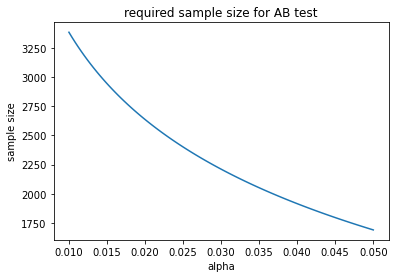

In [258]:
alphas = np.linspace(0.01, 0.05, 100)
ns = [compute_n(h_0, h_1, alpha, tail) for alpha in alphas]
fig, ax = plt.subplots()
ax.plot(alphas, ns)
ax.set_xlabel("alpha")
ax.set_ylabel("sample size")
ax.set_title("required sample size for AB test")

holding alpha and our null hypothesis constant, we can track the required sample size with respect to the desired conversion rate we'd like to detect. The larger effect we wish to see, the fewer samples we require. At first this may seem counterintuitive. Remember, however, that holding standard deviation constant, it is easier to discern two piles the further apart they are. 

Text(0.5, 1.0, 'required sample size for AB test')

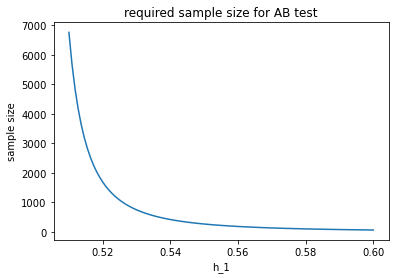

In [3]:
alpha = 0.05
h_0 = 0.5
h_1s = np.linspace(0.51, 0.6, 100)
ns = [compute_n(h_0, h_1, alpha, tail) for h_1 in h_1s]
fig, ax = plt.subplots()
ax.plot(h_1s, ns)
ax.set_xlabel("h_1")
ax.set_ylabel("sample size")
ax.set_title("required sample size for AB test")

### N vs B

in AB testing we often would like to consider the power level of our test. That is, the ability with which we can reduce the likelihood of accepting the null hypothesis when it is false. A common power level is 80%. This means that 80% of the time the null hypothesis is false we will safely reject it. 

In [5]:
tail = "right"
alpha = 0.05 # significance level
h_0 = 0.5
h_1 = 0.52
n = 3200

ns = np.arange(1000, 10000)
powers = []
for n in ns:
    # note, this se taken from https://towardsdatascience.com/the-power-of-a-b-testing-3387c04a14e3
    se = np.sqrt(h_0 * (1 - h_0) / n ) # standard error
    power, beta, ar = compute_power(h_0, h_1, se, alpha, tail, verbiose=0)
    powers.append(power)

Text(0.5, 1.0, 'required sample size for AB test')

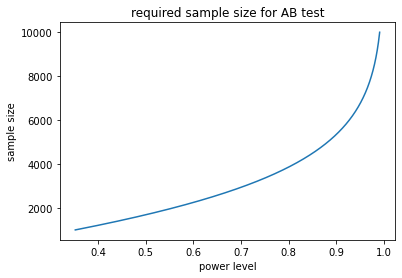

In [6]:
fig, ax = plt.subplots()
ax.plot(powers, ns)
ax.set_xlabel("power level")
ax.set_ylabel("sample size")
ax.set_title("required sample size for AB test")

## Visualizing the Hypotheses

It can be helpful to visualize the distributions of the two hypotheses we are testing.

### The Tradeoff between alpha and power level

* Type I error: False positive, is the area under the null hypothesis to the right of the acceptance boundary (for right tailed tests)
* Type II error: False negative, is the area under the alternative hypothesis to the left of the acceptance boundary (for right tailed tests)

As we shall see, there is a tradeoff between alpha and power level.

est. std error: 0.009
acceptance region < 0.515
power: 0.73, beta: 0.27
est. std error: 0.009
acceptance region < 0.521
power: 0.47, beta: 0.53


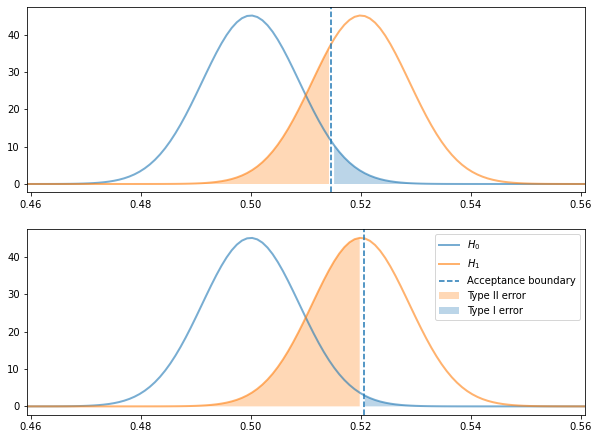

In [9]:
tail = "right"
alpha = 0.05 # significance level
h_0 = 0.5
h_1 = 0.52
n = 3200
se = np.sqrt(h_0 * (1 - h_0) / n ) # standard error
print(f"est. std error: {se:.3f}")
power, beta, acceptance_region = compute_power(h_0, h_1, se, alpha, tail)
print(f"power: {power:.2f}, beta: {beta:.2f}")

fig, (ax, ax_) = plt.subplots(2, 1, figsize=(10,7.5))

x = np.linspace(norm.ppf(0.01),
               norm.ppf(0.99), 5000)
y1 = norm.pdf(x, loc=h_0, scale=se)
y2 = norm.pdf(x, loc=h_1, scale=se)
y3 = norm.cdf(x, loc=h_0, scale=se)
ax.plot(x, y1, c='tab:blue', lw=2, alpha=0.6,
       label='$H_0$')
ax.plot(x, y2, c='tab:orange', lw=2, alpha=0.6,
       label='$H_1$')
ax.axvline(acceptance_region, ls='--', label='Acceptance boundary')
ax.fill_between(x, y2, where=x < acceptance_region, 
                facecolor='tab:orange', alpha=0.3,
               label="Type II error")
ax.fill_between(x, y1, where=x > acceptance_region, 
                facecolor='tab:blue', alpha=0.3,
               label="Type I error")
ax.set_xlim(x[min(np.argwhere(y1>0.001))[0]],x[max(np.argwhere(y2>0.001))[0]])

alpha = 0.01 # significance level
h_0 = 0.5
h_1 = 0.52
n = 3200
se = np.sqrt(h_0 * (1 - h_0) / n ) # standard error
print(f"est. std error: {se:.3f}")
power, beta, acceptance_region = compute_power(h_0, h_1, se, alpha, tail)
print(f"power: {power:.2f}, beta: {beta:.2f}")

x = np.linspace(norm.ppf(0.01),
               norm.ppf(0.99), 5000)
y1 = norm.pdf(x, loc=h_0, scale=se)
y2 = norm.pdf(x, loc=h_1, scale=se)
y3 = norm.cdf(x, loc=h_0, scale=se)
ax_.plot(x, y1, c='tab:blue', lw=2, alpha=0.6,
       label='$H_0$')
ax_.plot(x, y2, c='tab:orange', lw=2, alpha=0.6,
       label='$H_1$')
ax_.axvline(acceptance_region, ls='--', label='Acceptance boundary')
ax_.fill_between(x, y2, where=x < acceptance_region, 
                facecolor='tab:orange', alpha=0.3,
               label="Type II error")
ax_.fill_between(x, y1, where=x > acceptance_region, 
                facecolor='tab:blue', alpha=0.3,
               label="Type I error")

ax_.set_xlim(x[min(np.argwhere(y1>0.001))[0]],x[max(np.argwhere(y2>0.001))[0]])
ax_.legend()

### Greater lift, fewer tests, for the same power

The greater the amount of lift we are trying to detect, the fewer sample sizes we will need

est. std error: 0.009
acceptance region < 0.515
power: 0.73, beta: 0.27
est. std error: 0.017
acceptance region < 0.527
power: 0.77, beta: 0.23


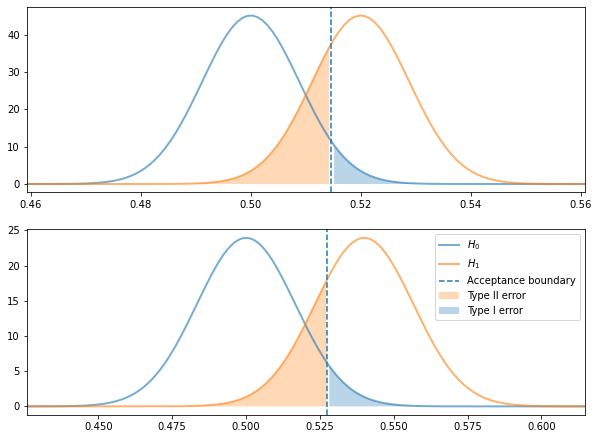

In [13]:
tail = "right"
alpha = 0.05 # significance level
h_0 = 0.5
h_1 = 0.52
n = 3200
se = np.sqrt(h_0 * (1 - h_0) / n ) # standard error
print(f"est. std error: {se:.3f}")
power, beta, acceptance_region = compute_power(h_0, h_1, se, alpha, tail)
print(f"power: {power:.2f}, beta: {beta:.2f}")

fig, (ax, ax_) = plt.subplots(2, 1, figsize=(10,7.5))

x = np.linspace(norm.ppf(0.01),
               norm.ppf(0.99), 5000)
y1 = norm.pdf(x, loc=h_0, scale=se)
y2 = norm.pdf(x, loc=h_1, scale=se)
y3 = norm.cdf(x, loc=h_0, scale=se)
ax.plot(x, y1, c='tab:blue', lw=2, alpha=0.6,
       label='$H_0$')
ax.plot(x, y2, c='tab:orange', lw=2, alpha=0.6,
       label='$H_1$')
ax.axvline(acceptance_region, ls='--', label='Acceptance boundary')
ax.fill_between(x, y2, where=x < acceptance_region, 
                facecolor='tab:orange', alpha=0.3,
               label="Type II error")
ax.fill_between(x, y1, where=x > acceptance_region, 
                facecolor='tab:blue', alpha=0.3,
               label="Type I error")
ax.set_xlim(x[min(np.argwhere(y1>0.001))[0]],x[max(np.argwhere(y2>0.001))[0]])

alpha = 0.05 # significance level
h_0 = 0.5
h_1 = 0.54
n = 900
se = np.sqrt(h_0 * (1 - h_0) / n ) # standard error
print(f"est. std error: {se:.3f}")
power, beta, acceptance_region = compute_power(h_0, h_1, se, alpha, tail)
print(f"power: {power:.2f}, beta: {beta:.2f}")

x = np.linspace(norm.ppf(0.01),
               norm.ppf(0.99), 5000)
y1 = norm.pdf(x, loc=h_0, scale=se)
y2 = norm.pdf(x, loc=h_1, scale=se)
y3 = norm.cdf(x, loc=h_0, scale=se)
ax_.plot(x, y1, c='tab:blue', lw=2, alpha=0.6,
       label='$H_0$')
ax_.plot(x, y2, c='tab:orange', lw=2, alpha=0.6,
       label='$H_1$')
ax_.axvline(acceptance_region, ls='--', label='Acceptance boundary')
ax_.fill_between(x, y2, where=x < acceptance_region, 
                facecolor='tab:orange', alpha=0.3,
               label="Type II error")
ax_.fill_between(x, y1, where=x > acceptance_region, 
                facecolor='tab:blue', alpha=0.3,
               label="Type I error")

ax_.set_xlim(x[min(np.argwhere(y1>0.001))[0]],x[max(np.argwhere(y2>0.001))[0]])
ax_.legend()

## Closing Notes

In the power law examples, we were estimating the standard error of the tests. In real AB test cases, we can use historical data to more accurately estiamte the standard error around the performance metric. In addition, we can update the estimations of N as the test is running, to more accurately determine when our test should conclude!